In [ ]:
# Start writing code here...
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import HTML, SVG, Math, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ConstantVectorSource,
                         ControllabilityMatrix, DiagramBuilder,
                         FirstOrderTaylorApproximation, Linearize,
                         LinearQuadraticRegulator, MatrixGain,
                         MeshcatVisualizerCpp, MultibodyPlant, Parser,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         ToLatex, WrapToSystem)
from pydrake.common.containers import namedview
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState)
from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
                                        StabilizingLQRController)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from underactuated import FindResource, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()


In [ ]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Meshcat is now available at https://931e8205-9a5c-4b8e-a3da-167564211c03.deepnoteproject.com


In [ ]:
def planar_quadrotor_example():
    def QuadrotorLQR(plant):
        context = plant.CreateDefaultContext()
        context.SetContinuousState(np.zeros([6, 1]))
        plant.get_input_port(0).FixValue(context, plant.mass * plant.gravity / 2. * np.array([1, 1]))

        Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2. / np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]])

        return LinearQuadraticRegulator(plant, context, Q, R)

    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())

    controller = builder.AddSystem(QuadrotorLQR(plant))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Setup visualization
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 4.0 if running_as_notebook else 0.1
    visualizer.start_recording()
    print("simulating...")
    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(np.random.randn(6,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))

planar_quadrotor_example()

simulating...
done.
generating animation...


In [ ]:
def planar_quadrotor_example():
    def QuadrotorLQR(plant):
        context = plant.CreateDefaultContext()
        context.SetContinuousState(np.zeros([6, 1]))
        plant.get_input_port(0).FixValue(context, plant.mass * plant.gravity / 2. * np.array([1, 1]))

        Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2. / np.pi)])
        R = np.array([[0.1, 0.05], [0.05, 0.1]])

        return LinearQuadraticRegulator(plant, context, Q, R)

    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())

    controller = builder.AddSystem(QuadrotorLQR(plant))
    print(controller)
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Setup visualization
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 4.0 if running_as_notebook else 0.1
    visualizer.start_recording()
    print("simulating...")
    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(np.random.randn(6,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))

planar_quadrotor_example()

<pydrake.systems.primitives.AffineSystem_[float] object at 0x7ff91d3ff470>
simulating...
done.
generating animation...


In [ ]:
def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(QuadrotorPlant())

    controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty('/Background','visible',False)
    MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0.0)
    context = simulator.get_mutable_context()

    # Simulate
    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(0.5*np.random.randn(12,))
        simulator.Initialize()
        simulator.AdvanceTo(4.0 if running_as_notebook else 0.1)

quadrotor_example()

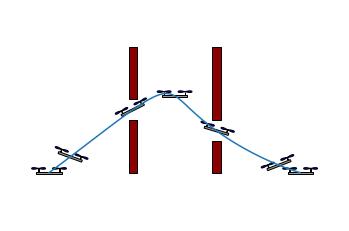

In [ ]:
# TODO(russt): Use drake.trajectories.PiecewisePolynomialTrajectory
#  instead (currently missing python bindings for the required constructor),
#  or port this class to C++.
class PPTrajectory():

    def __init__(self, sample_times, num_vars, degree, continuity_degree):
        self.sample_times = sample_times
        self.n = num_vars
        self.degree = degree

        self.prog = MathematicalProgram()
        self.coeffs = []
        for i in range(len(sample_times)):
            self.coeffs.append(
                self.prog.NewContinuousVariables(num_vars, degree + 1, "C"))
        self.result = None

        # Add continuity constraints
        for s in range(len(sample_times) - 1):
            trel = sample_times[s + 1] - sample_times[s]
            coeffs = self.coeffs[s]
            for var in range(self.n):
                for deg in range(continuity_degree + 1):
                    # Don't use eval here, because I want left and right
                    # values of the same time
                    left_val = 0
                    for d in range(deg, self.degree + 1):
                        left_val += (coeffs[var, d] * np.power(trel, d - deg) *
                                     math.factorial(d) /
                                     math.factorial(d - deg))
                    right_val = (self.coeffs[s + 1][var, deg] *
                                 math.factorial(deg))
                    self.prog.AddLinearConstraint(left_val == right_val)

        # Add cost to minimize highest order terms
        for s in range(len(sample_times) - 1):
            self.prog.AddQuadraticCost(np.eye(num_vars), np.zeros(
                (num_vars, 1)), self.coeffs[s][:, -1])

    def eval(self, t, derivative_order=0):
        if derivative_order > self.degree:
            return 0

        s = 0
        while s < len(self.sample_times) - 1 and t >= self.sample_times[s + 1]:
            s += 1
        trel = t - self.sample_times[s]

        if self.result is None:
            coeffs = self.coeffs[s]
        else:
            coeffs = self.result.GetSolution(self.coeffs[s])

        deg = derivative_order
        val = 0 * coeffs[:, 0]
        for var in range(self.n):
            for d in range(deg, self.degree + 1):
                val[var] += (coeffs[var, d] * np.power(trel, d - deg) *
                             math.factorial(d) / math.factorial(d - deg))

        return val

    def add_constraint(self, t, derivative_order, lb, ub=None):
        """Adds a constraint of the form d^deg lb <= x(t) / dt^deg <= ub."""
        if ub is None:
            ub = lb

        assert derivative_order <= self.degree
        val = self.eval(t, derivative_order)
        self.prog.AddLinearConstraint(val, lb, ub)

    def generate(self):
        self.result = Solve(self.prog)
        assert self.result.is_success()


tf = 3
zpp = PPTrajectory(sample_times=np.linspace(0, tf, 6),
                   num_vars=2,
                   degree=5,
                   continuity_degree=4)
zpp.add_constraint(t=0, derivative_order=0, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=0, derivative_order=2, lb=[0, 0])
zpp.add_constraint(t=1, derivative_order=0, lb=[2, 1.5])
zpp.add_constraint(t=2, derivative_order=0, lb=[4, 1])
zpp.add_constraint(t=tf, derivative_order=0, lb=[6, 0])
zpp.add_constraint(t=tf, derivative_order=1, lb=[0, 0])
zpp.add_constraint(t=tf, derivative_order=2, lb=[0, 0])
zpp.generate()

if False:  # Useful for debugging
    t = np.linspace(0, tf, 100)
    z = np.zeros((2, len(t)))
    knots = np.zeros((2, len(zpp.sample_times)))
    fig, ax = plt.subplots(zpp.degree + 1, 1)
    for deg in range(zpp.degree + 1):
        for i in range(len(t)):
            z[:, i] = zpp.eval(t[i], deg)
        for i in range(len(zpp.sample_times)):
            knots[:, i] = zpp.eval(zpp.sample_times[i], deg)
        ax[deg].plot(t, z.transpose())
        ax[deg].plot(zpp.sample_times, knots.transpose(), ".")
        ax[deg].set_xlabel("t (sec)")
        ax[deg].set_ylabel("z deriv " + str(deg))

fig, ax = plt.subplots()

t = np.linspace(0, tf, 100)
z = np.zeros((2, len(t)))

for i in range(len(t)):
    z[:, i] = zpp.eval(t[i])
ax.plot(z[0, :], z[1, :])

for t in np.linspace(0, tf, 7):
    x = zpp.eval(t)
    xddot = zpp.eval(t, 2)
    theta = np.arctan2(-xddot[0], (xddot[1] + 9.81))
    v = Quadrotor2DVisualizer(ax=ax)
    context = v.CreateDefaultContext()
    v.get_input_port(0).FixValue(context, [x[0], x[1], theta, 0, 0, 0])
    v.draw(context)

# Draw the (imaginary) obstacles
ax.fill(2 + np.array([-.1, -.1, .1, .1, -.1]),
        1.25 * np.array([0, 1, 1, 0, 0]),
        facecolor="darkred",
        edgecolor="k")
ax.fill(2 + np.array([-.1, -.1, .1, .1, -.1]),
        1.75 + 1.25 * np.array([0, 1, 1, 0, 0]),
        facecolor="darkred",
        edgecolor="k")
ax.fill(4 + np.array([-.1, -.1, .1, .1, -.1]),
        .75 * np.array([0, 1, 1, 0, 0]),
        facecolor="darkred",
        edgecolor="k")
ax.fill(4 + np.array([-.1, -.1, .1, .1, -.1]),
        1.25 + 1.75 * np.array([0, 1, 1, 0, 0]),
        facecolor="darkred",
        edgecolor="k")
ax.set_xlim([-1, 7])
ax.set_ylim([-.25, 3])
ax.set_title("");


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=931e8205-9a5c-4b8e-a3da-167564211c03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>